In [1]:
from docplex.mp.model import Model  #导出库，只用这一个就够了
import matplotlib.pyplot as plt#选取了用户47的365天的数据
import numpy as np
import pandas as pd
import csv
import cplex
from cplex.exceptions import CplexError
import time

In [2]:
 
#read file, for example
file_path = 'C:/Users/chenxihui/Desktop/code/project/2010.csv'
file = open(file_path)
data = []
for i in file.readlines():
    data.append(i)
file.close()

new_data = []
for row in data:
    tmp = row.strip('\n')  #去掉每行最后的回车符
    tmp = tmp.split(',')   #根据','来分割字符串，使之成为含有一个个数据的列表
    new_data.append(tmp)   #new_data的每一行数据就是一个列表
select_data = []

length=len(new_data)
for i in range(length):
    if(new_data[i][0]=='13'):#47
        select_data.append(new_data[i][3:])#[3:]

GC=[]
CL=[]
GG=[]
Battery=[]
Length_select_data = len(select_data)
for i in range(Length_select_data):
    if(select_data[i][0]=='GC'):
        GC.append(select_data[i][2:])
    elif(select_data[i][0]=='CL'):
        CL.append(select_data[i][2:])
    else:
        GG.append(select_data[i][2:])
        
Total_Load=[]
temp=[]
a=0.0
for i in range(Length_select_data):
    if(select_data[i][0]=='GC' and select_data[i+1][0]=='CL'):
        for j in range(len(select_data[i][2:])):
            a=pd.to_numeric(select_data[i][j+2])+pd.to_numeric(select_data[i+1][j+2])
            temp.append(a)
        Total_Load.append(temp)
    elif(select_data[i][0]=='GC' and select_data[i+1][0]!='CL'):
        Total_Load.append(select_data[i][2:])
    temp=[]
    
GC_temp=np.array(GC)
GC_array=[]
GC_array = GC_temp.astype(np.float)

GG_temp=np.array(GG)
GG_array=[]
GG_array = GG_temp.astype(np.float)*2

Total_Load_temp=np.array(Total_Load)
Total_Load_array=[]
Total_Load_array = Total_Load_temp.astype(np.float32)*2#功率
Total_Load_array[1]

print(len(Total_Load_array))


365


In [3]:
pg_bar=np.max(Total_Load_array)
T_flat=0.235018
T_fit=0.09
T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]

In [4]:
def milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar):
    expression=0
    tfit=[]
    model = Model()####对变量命名并且给出上下界
    var_list = np.arange(0,48,1)
    X1 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X1')#代表pg_import(pg+)，功率
    X2 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X2')#代表pg_export(pg-)
    Y1 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y1')#代表充电功率（pb+）
    Y2 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y2')#代表放电功率（pb-）
    dg=model.binary_var_list(var_list,name='dg')#决策变量电网电力流向（0：用户到电网）
    sb=model.binary_var_list(var_list,name='sb')#决策变量电池充电状态（0：放电）
    eb=model.continuous_var_list(var_list,lb=0,name='eb')#电池容量SOC
    tou=[]
    tou.extend(T_tou[i:])
    tou.extend(T_tou[0:i])#输入分时电价
    
    for j in range(48):
        #tfit.append(T_fit)
        expression+=tou[j]*X1[j]*dh#X1为pg+,X2为pg-,Y1为pb+,Y2为pb-
        expression-=T_fit*X2[j]*dh
    #约束条件（2）
        if(j+i<48):
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d][j+i]-efficiency_i*GG_array[d][j+i])
        else:
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d+1][j+i-48]-efficiency_i*GG_array[d+1][j+i-48])
        
    #约束条件（3）
        bat_state.append(bat_state[-1]+dh*efficiency_c*Y1[j]-(dh/efficiency_c)*Y2[j])#约束条件（3）
        eb[j]=bat_state[-1]
        model.add_constraint(eb[j]<=bat_max)#约束条件（12）
        model.add_constraint(eb[j]>=0)#约束条件（12）
    #约束条件（4）
        model.add_constraint(X1[j]-pg_bar*dg[j]<=0)
    #约束条件（5）
        model.add_constraint(X2[j]+pg_bar*dg[j]<=pg_bar)
    #约束条件（6）
        model.add_constraint(Y1[j]-pb_bar*sb[j]<=0)
    #约束条件（7）
        model.add_constraint(Y2[j]+pb_bar*sb[j]<=pb_bar)
    model.minimize(expression)#目标函数    
    sol = model.solve() #输出解
    temp = sol.get_all_values()
    return temp,bat_state[0]

In [5]:
def MILP_oneweek(Total_Load_array,GG_array):
    pb_bar=5
    bat_max=14
    efficiency_i=0.9
    efficiency_c=0.95
    dh=0.5
    pg_bar=float(np.max(Total_Load_array))
    T_flat=0.235018
    T_fit=0.09
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    init_state=14
    bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
    pg_import=[]
    pg_export=[]
    pb_c=[]
    pb_d=[]
    soc=[0.5*bat_max]
    a=time.time()
    for d in np.arange(184,191,1):        
        for i in range(48):
        #print(bat_state)
            temp=[]
            temp,before=milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar)
        #print(temp[96])
            soc.append(before+dh*efficiency_c*temp[96]-(dh/efficiency_c)*temp[144])#bat_state保存的是滚动域内48个时刻都要满足电池约束，所以一个遍历完后得
        #重置，而SOC是要输出的值
            bat_state=[]
            bat_state.append(soc[-1])
        #d=bat_state[-1]+0.455*a[0]-(0.5/0.91)*a[0]
        #print(bat_state[-1])
            pg_import.append(temp[0])
            pg_export.append(temp[48])
            pb_c.append(temp[96])
            pb_d.append(temp[144])
    return soc,pg_import,pg_export,pb_c,pb_d

In [ ]:
##对用户进行364天的SOC计算
def MILP_365(Total_Load_array,GG_array,user):
    L={0: 4,1: 5,2: 4,3: 4,4: 5,5: 5,6: 3,7: 3,8: 5,9: 5,10: 5,11: 8,12: 10,13: 7,14: 5,
 15: 5,16: 5,17: 4,18: 4,19: 10,20: 6,21: 5,22: 3,23: 4,24: 5,25: 6,26: 4,27: 9,28: 5,29: 10,
 30: 6,31: 5,32: 4,33: 3,34: 4,35: 5,36: 8,37: 5,38: 3,39: 4,40: 5,41: 6,42: 5,43: 4,
 44: 5,45: 4,46: 4,47: 5,48: 4,49: 6,50: 9,51: 7,52: 5,53: 4}
    #注意这里29和30是作者剔除的，这里考虑进来了
    days=364
    efficiency_i=0.9
    efficiency_c=0.95
    dh=0.5
    pg_bar=20
    T_flat=0.235018
    T_fit=0.09
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    if(L[user]==3 or L[user]==4):
        init_state=6.5
        pb_bar=4.2
    elif(L[user]==5 or L[user]==6):
        init_state=9.8
        pb_bar=5
    elif(L[user] in [7,8,9,10]):
        init_state=14
        pb_bar=5
        
    bat_max=init_state
    bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
    pg_import=[[] for _ in range(days)]
    pg_export=[[] for _ in range(days)]
    pb_c=[[] for _ in range(days)]
    pb_d=[[] for _ in range(days)]
    soc=[[] for _ in range(days)]
    soc[0]=[0.5*bat_max]
    
    for d in np.arange(0,days,1): 
        for i in range(48):
        #print(bat_state)
            temp=[]
            temp,before=milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar)
        #print(temp[96])
            if(i==47 and d<days-1):
                soc[d+1].append(abs(before+dh*efficiency_c*temp[96]-(dh/efficiency_c)*temp[144]))
            elif(i<47):     
                soc[d].append(abs(before+dh*efficiency_c*temp[96]-(dh/efficiency_c)*temp[144]))#bat_state保存的是滚动域内48个时刻都要满足电池约束，所以一个遍历完后得
        #重置，而SOC是要输出的值
            bat_state=[]
            bat_state.append(soc[d][-1])
        #d=bat_state[-1]+0.455*a[0]-(0.5/0.91)*a[0]
        #print(bat_state[-1])
            pg_import[d].append(abs(temp[0]))
            pg_export[d].append(abs(temp[48]))
            pb_c[d].append(abs(temp[96]))
            pb_d[d].append(abs(temp[144]))
    return soc,pg_import,pg_export,pb_c,pb_d

In [6]:
soc,pg_import,pg_export,pb_c,pb_d=MILP_oneweek(Total_Load_array,GG_array)

In [7]:
load=[]
GGG=[]
T_tou1=[]
for i in np.arange(184,191,1):
    load.extend(Total_Load_array[i])
    GGG.extend(GG_array[i])
    T_tou1.extend(T_tou)


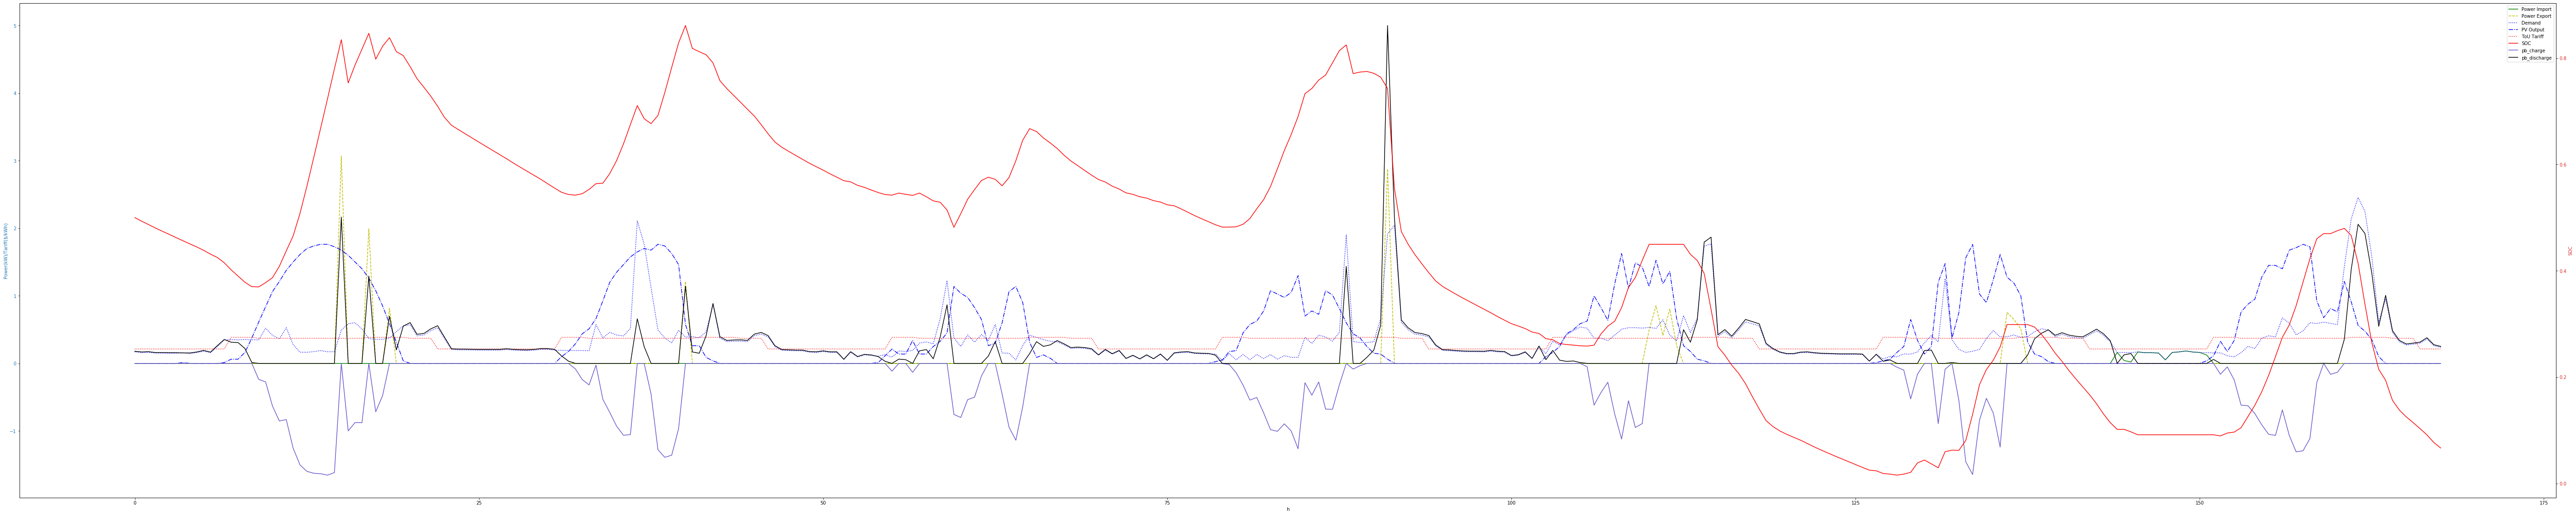

In [8]:
x = [0.5*i for i in range(48*7)]
y = [0.5*i for i in range(49)]

fig, ax1 = plt.subplots(figsize=(100,20))
color = 'tab:blue'
ax1.set_xlabel('h')
ax1.set_ylabel('Power(kW)/Tariff($/kWh)', color=color)
l1,=ax1.plot(x, np.array(pg_import), color='g',label='Power Import')
l2,=ax1.plot(x, np.array(pg_export), '--',color='y',label='Power Export')
l3,=ax1.plot(x, np.array(load),':',color='b',label='Demand')
l4,=ax1.plot(x, np.array(GGG),'-.',color='b',label='PV Output')
l5,=ax1.plot(x, T_tou1,':',color='r',label='ToU Tariff')
l7,=ax1.plot(x, -np.array(pb_c),color='slateblue',label='pb_charge')
l8,=ax1.plot(x, pb_d,color='k',label='pb_discharge')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('SOC', color=color)  # we already handled the x-label with ax1
l6,=ax2.plot(x, np.array(soc)[:336]/14, 'r',label='SOC')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(handles=[l1,l2,l3,l4,l5,l6,l7,l8],loc=1)
#fig.tight_layout()
plt.show()

In [9]:
len(soc)

337

In [10]:
cost_milp=[]
dh=0.5
for j in range(7): 
    cost=0
    for i in np.arange(48*j,48*(j+1),1):
        cost+=pg_import[i]*T_tou[i-48*j]*dh-pg_export[i]*T_fit*dh
    cost_milp.append(cost)
#cost_milp=abs(np.array(cost_milp))
cost_milp

[-1.6545568260622336,
 -0.34514285951685486,
 0.7859427116137171,
 0.12098961946611411,
 -0.6809971875779636,
 0.19621173009634968,
 -0.8741914587547408]

            MILP_2.5    MILP_5
2011-01-01 -1.654557 -2.072011
2011-01-02 -0.345143 -0.483808
2011-01-03  0.785943  0.775183
2011-01-04  0.120990  0.101570
2011-01-05 -0.680997 -0.433667
2011-01-06  0.196212 -0.204810
2011-01-07 -0.874191 -1.078069


Text(0, 0.5, '$')

D:\Users\chenxihui\Anaconda3\envs\chen\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\chenxihui\Anaconda3\envs\chen\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


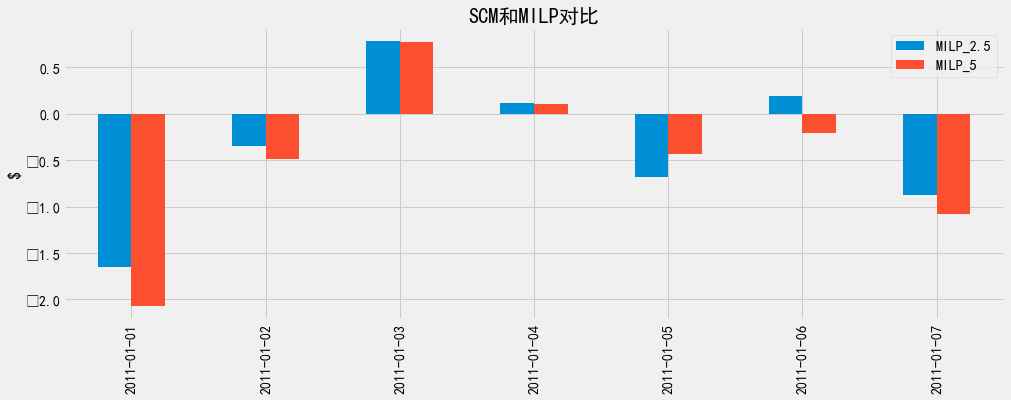

In [22]:
cost_milp_5=[-2.072010934443755,
 -0.48380793136943834,
 0.7751828756702942,
 0.10157022781019223,
 -0.43366660467314755,
 -0.2048095330119798,
 -1.0780693322285844]
#cost_scm=abs(np.array(cost_scm))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
#plt.style.use('fivethirtyeight') #设置图像风格样式
import seaborn as sns
sns.set_style({'font.sans-serif':['simhei','Arial']}) #设置字体样式，防止后面画图时中文字体显示出现问题
data=pd.DataFrame([np.array(cost_milp),np.array(cost_milp_5)])
data = pd.DataFrame(data.values.T, index=data.columns, columns=data.index)
data2=pd.DataFrame(data.values,
                  columns=['MILP_2.5','MILP_5'],
                  index=pd.period_range('2011-1-1','2011-1-7'))
print(data2)
data2.plot(kind='bar',
          figsize=(15,5),
          title='SCM和MILP对比')
plt.ylabel(u'$')

In [43]:
def milp_one(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i):
    expression=0
    tfit=[]
    model = Model()####对变量命名并且给出上下界
    var_list = np.arange(0,48,1)
    X1 = model.continuous_var_list(var_list,lb=0.0,ub=float(np.max(Total_Load_array)),
                              name='X1')#代表pg_import(pg+)，功率
    X2 = model.continuous_var_list(var_list,lb=0.0,ub=float(np.max(Total_Load_array)),
                              name='X2')#代表pg_export(pg-)
    Y1 = model.continuous_var_list(var_list,lb=0.0,ub=2,
                              name='Y1')#代表充电功率（pb+）
    Y2 = model.continuous_var_list(var_list,lb=0.0,ub=2,
                              name='Y2')#代表放电功率（pb-）
    dg=model.binary_var_list(var_list,name='dg')#决策变量电网电力流向（0：用户到电网）
    sb=model.binary_var_list(var_list,name='sb')#决策变量电池充电状态（0：放电）
    eb=model.continuous_var_list(var_list,lb=0,name='eb')#电池容量SOC
    tou=[]
    tou.extend(T_tou[i:])
    tou.extend(T_tou[0:i])#输入分时电价
    
    for j in range(48):
        #tfit.append(T_fit)
        expression+=tou[j]*X1[j]#X1为pg+,X2为pg-,Y1为pb+,Y2为pb-
        expression-=T_fit*X2[j]
    #约束条件（2）
        if(j+i<48):
            model.add_constraint(X1[j]-X2[j]-0.819*Y1[j]+(0.9/0.91)*Y2[j]==
                         Total_Load_array[0][j+i]-0.9*GG_array[0][j+i])
        else:
            model.add_constraint(X1[j]-X2[j]-0.819*Y1[j]+(0.9/0.91)*Y2[j]==
                         Total_Load_array[1][j+i-48]-0.9*GG_array[1][j+i-48])
        
    #约束条件（3）
        bat_state.append(bat_state[-1]+0.455*Y1[j]-(0.5/0.91)*Y2[j])#约束条件（3）
        eb[j]=bat_state[-1]
        model.add_constraint(eb[j]<=4)#约束条件（12）
        model.add_constraint(eb[j]>=0)#约束条件（12）
    #约束条件（4）
        model.add_constraint(X1[j]-float(np.max(Total_Load_array))*dg[j]<=0)
    #约束条件（5）
        model.add_constraint(X2[j]+float(np.max(Total_Load_array))*dg[j]<=float(np.max(Total_Load_array)))
    #约束条件（6）
        model.add_constraint(Y1[j]-2*sb[j]<=0)
    #约束条件（7）
        model.add_constraint(Y2[j]+2*sb[j]<=2)
    model.minimize(expression)#目标函数    
    sol = model.solve() #输出解
    temp = sol.get_all_values()
    return temp,bat_state[0]

In [61]:
def MILP_oneday(Total_Load_array,GG_array):
    pg_bar=np.max(Total_Load_array)
    pb_bar=2
    T_flat=0.235018
    T_fit=0.09
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    init_state=4
    bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
    pg_import=[]
    pg_export=[]
    soc=[]
    a=time.time()
    for i in range(48):
        #print(bat_state)
        temp=[]
        temp,before=milp_one(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i)
        #print(temp[96])
        soc.append(before+0.455*temp[96]-(0.5/0.91)*temp[144])#bat_state保存的是滚动域内48个时刻都要满足电池约束，所以一个遍历完后得
        #重置，而SOC是要输出的值
        bat_state=[]
        bat_state.append(soc[-1])
        #d=bat_state[-1]+0.455*a[0]-(0.5/0.91)*a[0]
        #print(bat_state[-1])
        pg_import.append(temp[0])
        pg_export.append(temp[48])
    return soc,pg_import,pg_export

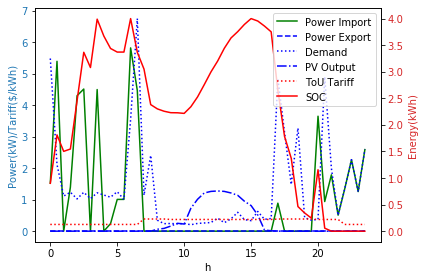

In [11]:
x = [0.5*i for i in range(48)]
y = [0.5*i for i in range(49)]

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('h')
ax1.set_ylabel('Power(kW)/Tariff($/kWh)', color=color)
l1,=ax1.plot(x, np.array(pg_import)*2, color='g',label='Power Import')
l2,=ax1.plot(x, np.array(pg_export)*2, '--',color='b',label='Power Export')
l3,=ax1.plot(x, np.array(Total_Load_array[0])*2,':',color='b',label='Demand')
l4,=ax1.plot(x, np.array(GG_array[0])*2,'-.',color='b',label='PV Output')
l5,=ax1.plot(x, T_tou,':',color='r',label='ToU Tariff')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Energy(kWh)', color=color)  # we already handled the x-label with ax1
l6,=ax2.plot(x, soc, 'r',label='SOC')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(handles=[l1,l2,l3,l4,l5,l6],loc=1)
fig.tight_layout()
plt.show()

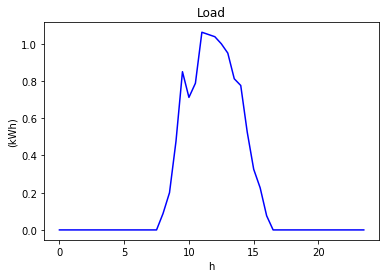

In [79]:
plt.figure(4)#2011
x=np.arange(0,24,0.5)
plt.plot(x,np.array(GG_array[0])*2, 'b')
plt.xlabel(u'h')
plt.ylabel(u'(kWh)') 
plt.title('Load')
plt.show()

In [37]:
def MILP_oneday(Total_Load_array,GG_array):
    pg_bar=np.max(Total_Load_array)
    pb_bar=2
    T_flat=0.235018
    T_fit=0.09
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    init_state=4
    bat_state=[2]#要输出的电池状态，这是0时刻的初始状态
    pg_import=[]
    pg_export=[]
    soc=[]
    tfit=[]
    expression=0
    a=time.time()
    model = Model()####对变量命名并且给出上下界
    var_list = np.arange(0,48,1)
    X1 = model.continuous_var_list(var_list,lb=0,ub=float(np.max(Total_Load_array)),
                              name='X1')
    X2 = model.continuous_var_list(var_list,lb=0,ub=float(np.max(Total_Load_array)),
                              name='X2')
    Y1 = model.continuous_var_list(var_list,lb=0,ub=4,
                              name='Y1')
    Y2 = model.continuous_var_list(var_list,lb=0,ub=4,
                              name='Y2')
    dg=model.binary_var_list(var_list,name='dg')
    sb=model.binary_var_list(var_list,name='sb')
    eb=model.continuous_var_list(var_list,lb=0,name='eb')
    for i in range(48):
        tou=[]
        tou.extend(T_tou[i:])
        tou.extend(T_tou[0:i])#输入分时电价
        for i in range(48):
            tfit.append(T_fit)
            expression+=T_tou[i]*X1[i]#X1为pg+,X2为pg-,Y1为pb+,Y2为pb-
            expression-=tfit[i]*X2[i]
    #约束条件（2）
            model.add_constraint(X1[i]-X2[i]-0.819*Y1[i]+(0.9/0.91)*Y2[i]==
                         Total_Load_array[0][i]-0.9*GG_array[0][i])
    #约束条件（3）
            bat_state.append(bat_state[-1]+0.455*Y1[i]-(0.5/0.91)*Y2[i])#约束条件（3）
            eb[i]=bat_state[-1]
            model.add_constraint(eb[i]<=4)#约束条件（12）
            model.add_constraint(eb[i]>=0)#约束条件（12）
    #约束条件（4）
            model.add_constraint(X1[i]-float(np.max(Total_Load_array))*dg[i]<=0)
    #约束条件（5）
            model.add_constraint(X2[i]+float(np.max(Total_Load_array))*dg[i]<=float(np.max(Total_Load_array)))
    #约束条件（6）
            model.add_constraint(Y1[i]-4*sb[i]<=0)
    #约束条件（7）
            model.add_constraint(Y2[i]+4*sb[i]<=4)
        model.minimize(expression)#目标函数    
        sol = model.solve() #输出解
        temp=sol.get_all_values()
        soc.append(bat_state[0]+0.455*temp[96]-(0.5/0.91)*temp[144])#bat_state保存的是滚动域内48个时刻都要满足电池约束，所以一个遍历完后得
        #重置，而SOC是要输出的值
        bat_state=[]
        bat_state.append(soc[-1])
        #d=bat_state[-1]+0.455*a[0]-(0.5/0.91)*a[0]
        #print(bat_state[-1])
        pg_import.append(temp[0])
        pg_export.append(temp[48])
    return soc,pg_import,pg_export

In [28]:
init_state=4
bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
tfit=[]
expression=0
a=time.time()
model = Model()####对变量命名并且给出上下界
var_list = np.arange(0,48,1)
X1 = model.continuous_var_list(var_list,lb=0,ub=float(np.max(Total_Load_array)),
                              name='X1')
X2 = model.continuous_var_list(var_list,lb=0,ub=float(np.max(Total_Load_array)),
                              name='X2')
Y1 = model.continuous_var_list(var_list,lb=0,ub=4,
                              name='Y1')
Y2 = model.continuous_var_list(var_list,lb=0,ub=4,
                              name='Y2')
dg=model.binary_var_list(var_list,name='dg')
sb=model.binary_var_list(var_list,name='sb')
eb=model.continuous_var_list(var_list,lb=0,name='eb')

for i in range(0):
    tou=[]
    tou.extend(T_tou[i:])
    tou.extend(T_tou[0:i])#输入分时电价
for i in range(48):
    tfit.append(T_fit)
    expression+=T_tou[i]*X1[i]#X1为pg+,X2为pg-,Y1为pb+,Y2为pb-
    expression-=tfit[i]*X2[i]
    #约束条件（2）
    model.add_constraint(X1[i]-X2[i]-0.819*Y1[i]+(0.9/0.91)*Y2[i]==
                         Total_Load_array[0][i]-0.9*GG_array[0][i])
    #约束条件（3）
    bat_state.append(bat_state[-1]+0.455*Y1[i]-(0.5/0.91)*Y2[i])#约束条件（3）
    eb[i]=bat_state[-1]
    model.add_constraint(eb[i]<=4)#约束条件（12）
    model.add_constraint(eb[i]>=0)#约束条件（12）
    #约束条件（4）
    model.add_constraint(X1[i]-float(np.max(Total_Load_array))*dg[i]<=0)
    #约束条件（5）
    model.add_constraint(X2[i]+float(np.max(Total_Load_array))*dg[i]<=float(np.max(Total_Load_array)))
    #约束条件（6）
    model.add_constraint(Y1[i]-4*sb[i]<=0)
    #约束条件（7）
    model.add_constraint(Y2[i]+4*sb[i]<=4)
    
model.minimize(expression)#目标函数    
sol = model.solve() #输出解
print(sol) #获取默认形式的输出
print(sol.get_all_values()) #获取所有的变量解
print(model.solution.get_objective_value())
e=time.time()
print('time cost: ',(e-s))

solution for: docplex_model12
objective: 3.14939
X1_0=0.167
X1_1=0.138
X1_2=0.096
X1_3=0.133
X1_4=0.103
X1_5=0.081
X1_6=0.095
X1_7=0.122
X1_8=0.100
X1_9=3.349
X1_10=0.079
X1_11=0.441
X1_12=0.196
X1_13=1.444
X1_19=0.152
X1_20=0.177
X1_21=0.076
X1_24=0.023
X1_27=2.505
X1_28=0.030
X1_29=0.011
X1_31=0.053
X1_32=0.248
X1_41=0.435
X1_42=0.264
X1_43=0.262
X1_44=0.304
X1_45=0.256
X1_46=0.134
X1_47=0.147
Y1_9=4.000
Y1_11=0.396
Y1_18=0.003
Y1_22=0.067
Y1_23=0.099
Y1_25=0.043
Y1_26=0.099
Y1_27=3.167
Y1_30=0.007
Y2_14=1.434
Y2_15=1.476
Y2_16=0.392
Y2_17=0.022
Y2_33=0.922
Y2_34=0.799
Y2_35=0.766
Y2_36=0.765
Y2_37=0.600
Y2_38=0.853
Y2_39=1.022
Y2_40=1.116
dg_0=1
dg_1=1
dg_2=1
dg_3=1
dg_4=1
dg_5=1
dg_6=1
dg_7=1
dg_8=1
dg_9=1
dg_10=1
dg_11=1
dg_12=1
dg_13=1
dg_14=1
dg_15=1
dg_16=1
dg_17=1
dg_18=1
dg_19=1
dg_20=1
dg_21=1
dg_22=1
dg_23=1
dg_24=1
dg_25=1
dg_26=1
dg_27=1
dg_28=1
dg_29=1
dg_30=1
dg_31=1
dg_32=1
dg_33=1
dg_34=1
dg_35=1
dg_36=1
dg_37=1
dg_38=1
dg_39=1
dg_40=1
dg_41=1
dg_42=1
dg_43=1
dg_44=1


NameError: name 's' is not defined

In [30]:
temp=sol.get_all_values()
a=temp[96:144]
b=temp[144:192]

soc=[2]
soc.append(soc[-1]+0.455*temp[96]-(0.5/0.91)*temp[144])
soc

[2, 2.0]

In [15]:
init_state=4
bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
pg_out=[0]#对应着pg+，输出
pg_in=[0]#对应着pg-，输出
pb_in=[0]#对应着pb+，输出
pb_out=[0]#对应着pb-，输出
tfit=[]
expression=0
model = Model()####对变量命名并且给出上下界
var_list = [i for i in range(96)]
X = model.continuous_var_list(var_list,lb=0,ub=float(np.max(Total_Load_array)),
                              name='X')
Y = model.continuous_var_list(var_list,lb=0,ub=4,
                              name='Y')
dg=model.binary_var(name='dg')
sb=model.binary_var(name='sb')
eb=model.continuous_var(lb=0,name='eb')
for i in range(48):
    tou=[]
    tou.extend(T_tou[i:])
    tou.extend(T_tou[0:i])#输入分时电价
for j in range(48):
    tfit.append(T_fit)
for i in range(48):
    expression+=tou[i]*X[i]
    expression-=tfit[i]*Y[i]


In [ ]:
my_rhs=[]
for i in range(48):#对一天时间范围内进行滚动求解   
    my_rhs = float(Total_Load_array[0][i]-0.9*GG_array[0][i])
for i in range(48):
    my_rhs.append(float(bat_state[i]+0.455*pb_in[i]-(0.5/0.91)*pb_out[i]))
              
              0.0,float(np.max(Total_Load_array)),0.0,4.0]#约束条件等式的右侧值，是变化的
    tou=[]
    tou.extend(T_tou[i:])
    tou.extend(T_tou[0:i])#输入分时电价
    for j in range(48):
        tou.append(T_fit)
    for i in range(99):
        tou.append(0)#到此处就建立了一天的所有参数的系数，共有48*4+2+1=195个，包含两个01决策变量
    print(len(tou))
    
    mlp.solve()
    x = mlp.solution.get_values()
    bat_state.append(x[-1])
    pg_out.append(x[0])#对应着pg+，输出
    pg_in.append(x[48])#对应着pg-，输出
    pb_in.append(x[96])#对应着pb+，输出
    pb_out.append(x[144])#对应着pb-，输出
    tou=[]#为了组合的大小始终为195所必须的操作

In [42]:
import numpy as np
import time
s = time.time()
x = np.arange(0,10,1)
y = np.arange(0,10,1)
for i in range(10):
    x[i]+=1
for i in range(10):
    y[i]+=1
print(y)
e = time.time()
print('time cost: ',(e-s))

[ 1  2  3  4  5  6  7  8  9 10]
time cost:  0.0009970664978027344


In [49]:
import numpy as np
import time
s = time.time()
x = np.arange(0,10,1)
y = np.arange(0,10,1)
for i in range(10):
    x[i]+=1
    y[i]+=1
print(y)
e = time.time()
print('time cost: ',(e-s))

[ 1  2  3  4  5  6  7  8  9 10]
time cost:  0.0009672641754150391


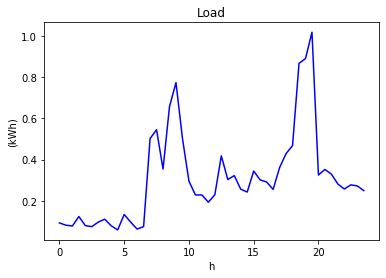

In [19]:
plt.figure(4)#2011
plt.plot(x, Total_Load_array[1], 'b')
plt.xlabel(u'h')
plt.ylabel(u'(kWh)') 
plt.title('Load')
plt.show()